# Projet de Trading Algorithmique : Arbitrage Statistique

## 1. Objectif du Projet

Inspiré par des compétitions de finance quantitative comme le **"Quantitative Edge Challenge" de JP Morgan et AmplifyME**, mon objectif avec ce projet était de développer un environnement de backtesting complet et cohérent. Je voulais recréer un outil ressemblant à ceux utilisés dans ces challenges pour mettre en pratique une stratégie de trading algorithmique.

La stratégie que j'implémente ici est un **arbitrage statistique**, aussi appelé *pairs trading* : une stratégie de marché neutre qui consiste à trader l'écart entre deux actifs très corrélés, en pariant sur son retour à la moyenne. Le principe fondamental est la *réversion à la moyenne* : la tendance statistique d'une variable à revenir vers sa moyenne à long terme. On parie que les écarts extrêmes sont temporaires.

Pour que cela fonctionne, mon hypothèse est que l'écart de performance entre un ETF (QQQ) et un panier synthétique d'actions est *stationnaire* : une propriété d'un signal dont les caractéristiques statistiques (moyenne, variance) sont constantes dans le temps, le rendant ainsi prédictible.

In [1]:
# 1. IMPORTS ET CONFIGURATION

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta

plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

## 2. Développement du Moteur de Backtesting

Pour simuler mes trades de manière réaliste, j'ai créé mon propre moteur de backtesting en Python. Il est composé de deux classes (`Position` et `MyTradingEnginePro`) pour gérer le portefeuille, les ordres, les commissions et l'enregistrement des performances. J'ai également développé une fonction `create_trading_dashboard` qui génère le rapport visuel final.

Cette cellule contient toute la "mécanique" et n'a pas besoin d'être modifiée.

In [2]:
# 2. MOTEUR DE TRADING, OUTILS DE CALCUL ET DASHBOARD

# --- Classe pour une position unique ---
class Position:
    """Représente une position unique sur un actif."""
    def __init__(self, ticker):
        self.ticker = ticker
        self.volume = 0
        self.avg_entry_price = 0.0
        self.realized_pnl = 0.0

    def update(self, transaction_volume, price):
        """Met à jour la position après une transaction et retourne le P&L réalisé."""
        total_cost_before = self.volume * self.avg_entry_price
        pnl_from_trade = 0.0
        
        is_closing = (self.volume > 0 and transaction_volume < 0) or \
                     (self.volume < 0 and transaction_volume > 0)

        if is_closing:
            volume_closed = min(abs(self.volume), abs(transaction_volume))
            pnl = volume_closed * (price - self.avg_entry_price)
            if self.volume < 0: 
                pnl = -pnl
            self.realized_pnl += pnl
            pnl_from_trade = pnl

        new_total_volume = self.volume + transaction_volume
        if new_total_volume != 0:
            if not is_closing:
                total_cost_after = total_cost_before + (transaction_volume * price)
                self.avg_entry_price = total_cost_after / new_total_volume
        else: # Position complètement fermée
            self.avg_entry_price = 0
        
        self.volume = new_total_volume
        return pnl_from_trade
        
    def get_unrealized_pnl(self, current_price):
        """Calcule le P&L non-réalisé de la position actuelle."""
        if self.volume == 0:
            return 0.0
        return self.volume * (current_price - self.avg_entry_price)

# --- Le Moteur de Trading "Pro" ---
class MyTradingEnginePro:
    """Orchestre le backtest, gère le portefeuille et enregistre les performances."""
    def __init__(self, initial_balance=1_000_000, commission_rate=0.0005):
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.commission_rate = commission_rate
        self.positions = {}
        self.trade_log = []
        self.equity_history = []

    def execute_order(self, ticker, volume, action, price, timestamp):
        """Exécute un ordre et met à jour le portefeuille."""
        if volume <= 0 or price <= 0: return
        
        trade_value = volume * price
        commission = trade_value * self.commission_rate
        self.balance -= commission
        
        transaction_volume = volume if action.upper() == 'BUY' else -volume
        
        if action.upper() == 'BUY':
            self.balance -= trade_value
        else: # SELL
            self.balance += trade_value
            
        if ticker not in self.positions:
            self.positions[ticker] = Position(ticker)
            
        pnl_from_trade = self.positions[ticker].update(transaction_volume, price)
        
        self.trade_log.append({
            'timestamp': timestamp,
            'ticker': ticker,
            'action': action,
            'volume': volume,
            'price': price,
            'commission': commission,
            'realized_pnl': pnl_from_trade
        })

    def get_portfolio_value(self, current_prices):
        """Calcule la valeur totale du portefeuille (cash + valeur des actifs)."""
        assets_value = 0.0
        for ticker, position in self.positions.items():
            assets_value += position.volume * current_prices.get(ticker, 0)
        return self.balance + assets_value

    def record_timestamp(self, timestamp, current_prices):
        """Enregistre l'état complet du portefeuille, incluant l'exposition au marché."""
        unrealized_pnl = 0.0
        long_exposure = 0.0
        short_exposure = 0.0
        
        for ticker, position in self.positions.items():
            price = current_prices.get(ticker, 0)
            unrealized_pnl += position.get_unrealized_pnl(price)
            
            position_value = abs(position.volume) * price
            if position.volume > 0:
                long_exposure += position_value
            elif position.volume < 0:
                short_exposure += position_value
            
        realized_pnl = sum(pos.realized_pnl for pos in self.positions.values())
        net_pnl = realized_pnl + unrealized_pnl
        portfolio_value = self.initial_balance + net_pnl
        
        net_exposure = long_exposure - short_exposure
        
        self.equity_history.append({
            'timestamp': timestamp, 
            'portfolio_value': portfolio_value,
            'realized_pnl': realized_pnl,
            'unrealized_pnl': unrealized_pnl,
            'net_pnl': net_pnl,
            'net_exposure': net_exposure
        })
    
    def get_results(self):
        """Retourne les résultats de la simulation sous forme de DataFrames."""
        if not self.equity_history: return None
        equity_df = pd.DataFrame(self.equity_history).set_index('timestamp')
        trades_df = pd.DataFrame(self.trade_log).set_index('timestamp')
        return {'equity_curve': equity_df, 'trades': trades_df}

# --- Fonctions de Calcul de Performance ---
def calculate_performance_metrics(equity_curve, trades, initial_balance):
    """Calcule les indicateurs de performance clés (KPIs)."""
    metrics = {}
    metrics['realized_pnl'] = trades['realized_pnl'].sum()
    metrics['return_on_capital'] = (equity_curve['portfolio_value'].iloc[-1] / initial_balance) - 1
    metrics['total_trades'] = len(trades)
    winning_trades = trades[trades['realized_pnl'] > 0]
    metrics['win_ratio'] = len(winning_trades) / metrics['total_trades'] if metrics['total_trades'] > 0 else 0
    returns = equity_curve['portfolio_value'].pct_change().dropna()
    metrics['annual_volatility'] = returns.std() * np.sqrt(252) if not returns.empty else 0.0
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    metrics['sharpe_ratio'] = sharpe_ratio
    cumulative_returns = (1 + returns).cumprod()
    if not cumulative_returns.empty:
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        metrics['max_drawdown'] = drawdown.min()
    else:
        metrics['max_drawdown'] = 0.0
    return metrics

# --- Fonction de Création du Dashboard (Version Finale avec Paramètres) ---
def create_trading_dashboard(engine, strategy_params={}):
    """Génère un tableau de bord visuel complet, incluant les paramètres de la stratégie."""
    results = engine.get_results()
    if not results or results['equity_curve'].empty:
        print("Le moteur n'a pas d'historique à analyser.")
        return

    equity_curve = results['equity_curve']
    trades = results['trades']
    metrics = calculate_performance_metrics(equity_curve, trades, engine.initial_balance)
    last_pnl = equity_curve.iloc[-1]
    
    fig = plt.figure(figsize=(16, 18))
    fig.patch.set_facecolor('#121212')
    fig.suptitle('Dashboard de Performance de la Stratégie', fontsize=24, weight='bold')
    
    gs = fig.add_gridspec(4, 1, height_ratios=[2, 2, 1, 2.5])

    # --- GRAPHIQUE 1: Equity Curve ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(equity_curve.index, equity_curve['portfolio_value'], color='#6bbdff', linewidth=2, label='Valeur du Portefeuille')
    ax0.set_facecolor('#1e1e1e')
    ax0.set_title('Courbe de Performance (Equity Curve)', fontsize=18, weight='bold', pad=20)
    ax0.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax0.legend(fontsize=12)
    ax0.set_ylabel("Valeur Totale ($)")

    # --- GRAPHIQUE 2: Décomposition du P&L ---
    ax1 = fig.add_subplot(gs[1])
    ax1.plot(equity_curve.index, equity_curve['net_pnl'], color='white', linewidth=1.5, label='P&L Net')
    ax1.plot(equity_curve.index, equity_curve['realized_pnl'], color='#2ca02c', linestyle='--', linewidth=1.5, label='P&L Réalisé')
    ax1.fill_between(equity_curve.index, equity_curve['unrealized_pnl'], 0, color='#ff9999', alpha=0.4, label='P&L non-réalisé')
    ax1.set_facecolor('#1e1e1e')
    ax1.set_title('Décomposition du P&L', fontsize=18, weight='bold', pad=20)
    ax1.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax1.legend(fontsize=12)
    ax1.set_ylabel("Profit & Loss ($)")

    # --- GRAPHIQUE 3: Exposition Nette au Marché ---
    ax2 = fig.add_subplot(gs[2])
    ax2.plot(equity_curve.index, equity_curve['net_exposure'], color='#ffb3e6', linewidth=1.5, label='Exposition Nette')
    ax2.axhline(0, color='white', linestyle='--', linewidth=0.5)
    ax2.set_facecolor('#1e1e1e')
    ax2.set_title('Exposition Nette au Marché', fontsize=18, weight='bold', pad=20)
    ax2.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='#555555')
    ax2.legend(fontsize=12)
    ax2.set_ylabel("Valeur Nette ($)")

    # --- SECTION 4 : Indicateurs de Performance et Tartelettes ---
    gs3 = gs[3].subgridspec(1, 3, wspace=0.3)
    
    ax3_kpi = fig.add_subplot(gs3[0])
    ax3_kpi.axis('off')

    params_text = (
        f"\n\n--- Paramètres Stratégie ---\n"
        f"Window: {strategy_params.get('window', 'N/A')}\n"
        f"Entry Z-Score: {strategy_params.get('entry', 'N/A'):.2f}\n"
        f"Exit Z-Score: {strategy_params.get('exit', 'N/A'):.2f}"
    )
    
    kpi_text = (f"P&L Net: ${last_pnl['net_pnl']:,.2f}\n"
                f"  └ P&L Réalisé: ${last_pnl['realized_pnl']:,.2f}\n"
                f"  └ P&L non-réalisé: ${last_pnl['unrealized_pnl']:,.2f}\n\n"
                f"Retour s/ Capital: {metrics['return_on_capital']:.2%}\n"
                f"Win Ratio: {metrics['win_ratio']:.2%}\n"
                f"Max Drawdown: {metrics['max_drawdown']:.2%}\n"
                f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}"
                f"{params_text}"
               )

    ax3_kpi.text(0.5, 0.5, kpi_text, ha='center', va='center', fontsize=12,
                 bbox=dict(boxstyle="round,pad=1.5", fc="#1f2c56", ec="lightsteelblue", lw=1))
    ax3_kpi.set_title('Performance & Paramètres', fontsize=18, weight='bold', pad=20)

    ax3_pie1 = fig.add_subplot(gs3[1])
    top_assets = trades['ticker'].value_counts().nlargest(6)
    colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
    ax3_pie1.pie(top_assets.values, labels=top_assets.index, autopct='%1.1f%%',
                 startangle=90, colors=colors_pie, wedgeprops={'edgecolor': '#121212', 'linewidth': 2}, textprops={'fontsize': 12})
    ax3_pie1.set_title('Top Actifs Tradés', fontsize=18, weight='bold', pad=20)
    
    ax3_pie2 = fig.add_subplot(gs3[2])
    wins = (trades['realized_pnl'] > 0).sum()
    losses = (trades['realized_pnl'] < 0).sum()
    if wins > 0 or losses > 0:
        ax3_pie2.pie([wins, losses], labels=['Gains', 'Pertes'], autopct='%1.1f%%',
                     startangle=90, colors=['#2ca02c', '#d62728'], wedgeprops={'edgecolor': '#121212', 'linewidth': 2}, textprops={'fontsize': 12})
    else:
        ax3_pie2.text(0.5, 0.5, 'Aucun trade complété', ha='center', va='center', alpha=0.7)
        ax3_pie2.axis('off')
    ax3_pie2.set_title('Ratio Gains / Pertes', fontsize=18, weight='bold', pad=20)
    
    plt.tight_layout(pad=3.0)
    plt.show()

print("Moteur de trading et outils d'analyse prêts (Version Finale).")

Moteur de trading et outils d'analyse prêts (Version Finale).


## 3. Préparation des Données

Pour ce projet, je récupère les données boursières via la librairie `yfinance`. J'ai sélectionné une période de 2 ans pour avoir un échantillon robuste et tester la stratégie sur différentes conditions de marché. L'ETF de référence choisi est le QQQ (représentant le Nasdaq-100), que je renomme en 'FAANG' pour coller au thème du challenge. 

Le code est conçu pour être robuste, en téléchargeant chaque actif individuellement pour éviter les erreurs et en s'assurant que toutes les données sont bien présentes avant de continuer.



In [3]:
# 3. CHARGEMENT DES DONNÉES

end_date = datetime.now()
start_date = end_date - timedelta(days=2 * 365)
tickers = ['AAPL', 'AMZN', 'META', 'GOOGL', 'NFLX', 'QQQ']
all_series = []

for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval="1d", progress=False, auto_adjust=True)
        if not data.empty and 'Close' in data.columns:
            close_series = data['Close']
            close_series.name = ticker
            all_series.append(close_series)
    except Exception as e:
        print(f"  /!\\ ERREUR lors du téléchargement de {ticker}: {e}")

historical_prices = pd.concat(all_series, axis=1).dropna()

historical_prices.rename(columns={'META': 'FB', 'QQQ': 'FAANG'}, inplace=True)

required_columns = ['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX', 'FAANG']

if not all(col in historical_prices.columns for col in required_columns):
    print("\nERREUR: Données manquantes après l'assemblage. Arrêt.")
else:
    print(f"Données disponibles du {historical_prices.index.min().date()} au {historical_prices.index.max().date()}.")

Données disponibles du 2023-10-25 au 2025-10-23.


## 4. Ma Stratégie : Parier sur "l'Effet Élastique"

Ici, je définis et teste ma logique de trading. L'idée est de modéliser la relation entre mes deux actifs (l'ETF réel et l'ETF synthétique) comme s'ils étaient reliés par un **élastique invisible**.

### Étape 1 : Créer l'Élastique (Le signal `diff`)

Pour commencer, je dois pouvoir comparer mes deux actifs sur une même base. Je normalise donc leurs prix pour qu'ils partent tous les deux d'une valeur de 100 le premier jour. Cela me permet de comparer leur performance en pourcentage.

L'écart entre ces deux performances est mon signal `diff`. C'est la **longueur de mon élastique** à chaque instant.

### Étape 2 : Mesurer la Tension de l'Élastique (Le Z-Score)

Le problème est que parfois, les deux actifs peuvent dériver ensemble vers le haut ou vers le bas, tout en gardant un écart constant. Ce n'est pas la position des actifs qui m'intéresse, mais bien la **tension** de l'élastique qui les relie.

C'est là que le *Z-Score* intervient. C'est mon "tensiomètre". Il ignore la direction générale du marché et mesure uniquement à quel point l'élastique est tendu par rapport à sa tension habituelle (calculée sur les 60 derniers jours).



Voici comment j'interprète les mesures de ce tensiomètre :
* **Z-Score > 2 :** L'élastique est **anormalement tendu** dans un sens. La force de rappel devrait le faire se contracter. **SIGNAL DE TRADE !**
* **Z-Score < -2 :** L'élastique est **anormalement tendu** dans l'autre sens. La force de rappel devrait aussi le faire se contracter. **SIGNAL DE TRADE !**
* **Z-Score proche de 0 :** L'élastique est détendu, à sa longueur de repos. La situation est normale, on ne fait rien.

### Étape 3 : Définir les Règles du Jeu (La Stratégie de Trading)

Ma stratégie se base directement sur la lecture du tensiomètre :
1.  **J'ouvre une position** dès que l'élastique est très tendu (Z-score > 2 ou < -2), en pariant sur son retour à la normale.
2.  **Je ferme ma position** (et j'encaisse mes gains/pertes) dès que l'élastique est de nouveau détendu (Z-score revenu proche de 0).

---
Pour tenter de maximiser les performances de la stratégie (le P&L, le ratio de Sharpe, etc.), je joue principalement sur trois "potentiomètres" dans la cellule de code ci-dessous. Chaque simulation est réaliste car elle inclut une **commission de 0.05% sur chaque transaction**. Les leviers d'optimisation sont :
* `window` : La "mémoire" du signal, c'est-à-dire la période de calcul de la moyenne et de l'écart-type.
* `entry_threshold` : La sélectivité de la stratégie, soit le niveau de "tension" de l'élastique nécessaire pour déclencher un trade.
* `exit_threshold` : La réactivité de la sortie, soit le niveau de "détente" qui me dit de fermer le trade.


In [4]:
# 4.1. CALCUL DU SIGNAL

components = ['AAPL', 'AMZN', 'FB', 'GOOGL', 'NFLX']
rebased_prices = pd.DataFrame()

for ticker in components:
    rebased_prices[ticker] = (historical_prices[ticker] / historical_prices[ticker].iloc[0]) * 100

synthetic_etf = rebased_prices.mean(axis=1)
rebased_faang = (historical_prices['FAANG'] / historical_prices['FAANG'].iloc[0]) * 100
diff = rebased_faang - synthetic_etf
window=60

rolling_mean = diff.rolling(window=window).mean()
rolling_std = diff.rolling(window=window).std()

z_score = (diff - rolling_mean) / rolling_std
print(z_score.describe())

count    442.000000
mean      -0.846742
std        1.093078
min       -3.998399
25%       -1.614515
50%       -0.960301
75%       -0.222918
max        1.700728
dtype: float64


### 4.2. Paramètres et Visualisation

C'est ici que je définis tous les leviers de ma stratégie. Je peux ajuster ces paramètres et ré-exécuter cette cellule rapidement pour voir le graphique du signal avec les nouveaux seuils, avant de lancer le long backtest.

Voici les paramètres que j'ai choisi ici :  {'window': 60, 'entry': 1.5, 'exit': 0.2}


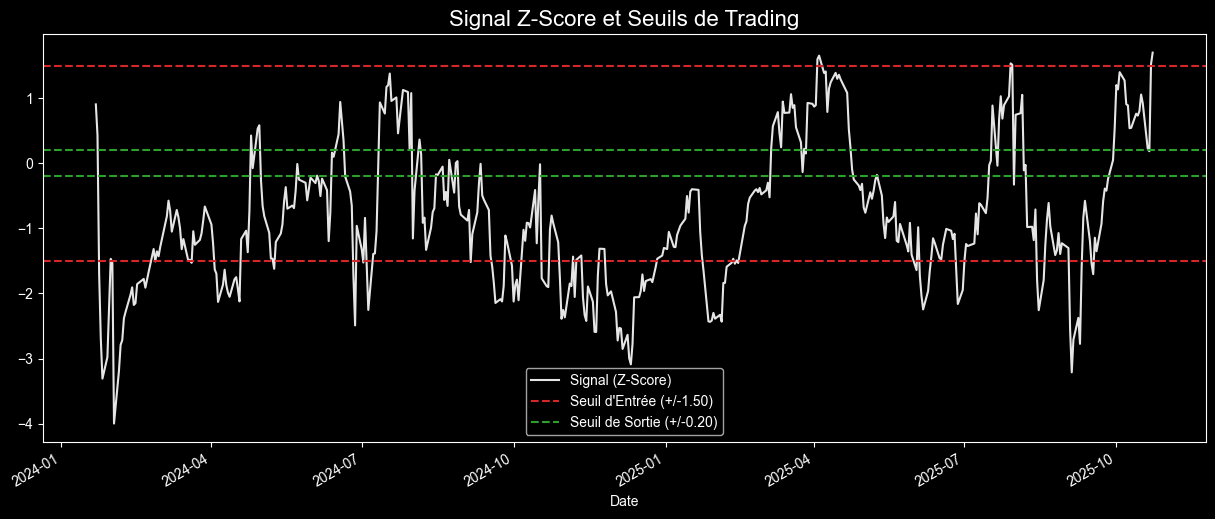

In [8]:
# 4.2. PARAMÈTRES ET VISUALISATION 

# Levier 1: Timing d'Entrée/Sortie ---
entry_threshold = 1.5
exit_threshold = 0.2

# Levier 2: Fenêtre de Calcul ---
window = 60

# Levier 3: Taille de la Position ---
trade_volume_etf = 1000
trade_volume_stock = 200

strategy_params = {'window': window, 'entry': entry_threshold, 'exit': exit_threshold}
print("Voici les paramètres que j'ai choisi ici : ", strategy_params)


# Visualisation du Signal
plt.figure(figsize=(15, 6))
z_score.plot(label='Signal (Z-Score)', color='white', alpha=0.9)
plt.axhline(entry_threshold, color='#d62728', linestyle='--', label=f'Seuil d\'Entrée (+/-{entry_threshold:.2f})')
plt.axhline(-entry_threshold, color='#d62728', linestyle='--')
plt.axhline(exit_threshold, color='#2ca02c', linestyle='--', label=f'Seuil de Sortie (+/-{exit_threshold:.2f})')
plt.axhline(-exit_threshold, color='#2ca02c', linestyle='--')
plt.title('Signal Z-Score et Seuils de Trading', fontsize=16)
plt.legend(); plt.show()

### 4.3. Exécution de la Simulation (Backtest)

Cette cellule prend le signal et les paramètres définis ci-dessus et exécute la simulation de trading sur tout l'historique.

In [9]:
# ==============================================================================
# 4.3. EXÉCUTION DU BACKTEST
# ==============================================================================
engine = MyTradingEnginePro(initial_balance=1_000_000)
trade_state, trade_queue, position_type = 'IDLE', [], None

for timestamp, row in historical_prices.iterrows():
    current_prices = row; current_z_score = z_score.loc[timestamp]
    if pd.isna(current_z_score):
        engine.record_timestamp(timestamp, current_prices); continue
    
    if trade_state == 'ENTERING':
        if trade_queue:
            ticker, volume, action = trade_queue.pop(0)
            engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
        if not trade_queue: trade_state = 'IN_POSITION'
    elif trade_state == 'EXITING':
        if trade_queue:
            ticker, volume, action = trade_queue.pop(0)
            engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
        if not trade_queue: trade_state = 'IDLE'
    elif trade_state == 'IN_POSITION':
        if abs(current_z_score) < exit_threshold:
            trade_state = 'EXITING'
            for t, pos in list(engine.positions.items()):
                if pos.volume != 0:
                    action_to_close = 'SELL' if pos.volume > 0 else 'BUY'
                    trade_queue.append((t, abs(pos.volume), action_to_close))
            if trade_queue:
                ticker, volume, action = trade_queue.pop(0)
                engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
    elif trade_state == 'IDLE':
        if current_z_score > entry_threshold:
            trade_state = 'ENTERING'; position_type = 'SHORT_ETF'
            trade_queue = [('FAANG', trade_volume_etf, 'SELL')] + [(comp, trade_volume_stock, 'BUY') for comp in components]
        elif current_z_score < -entry_threshold:
            trade_state = 'ENTERING'; position_type = 'LONG_ETF'
            trade_queue = [('FAANG', trade_volume_etf, 'BUY')] + [(comp, trade_volume_stock, 'SELL') for comp in components]
        if trade_state == 'ENTERING':
            if trade_queue:
                ticker, volume, action = trade_queue.pop(0)
                engine.execute_order(ticker, volume, action, current_prices[ticker], timestamp)
    engine.record_timestamp(timestamp, current_prices)


## 5. Visualisation des Résultats

Cette cellule finale exécute la fonction de dashboarding pour générer le rapport visuel de la simulation. C'est le moment de vérité, où j'analyse les résultats de la dernière configuration de paramètres pour décider des prochaines étapes d'optimisation.

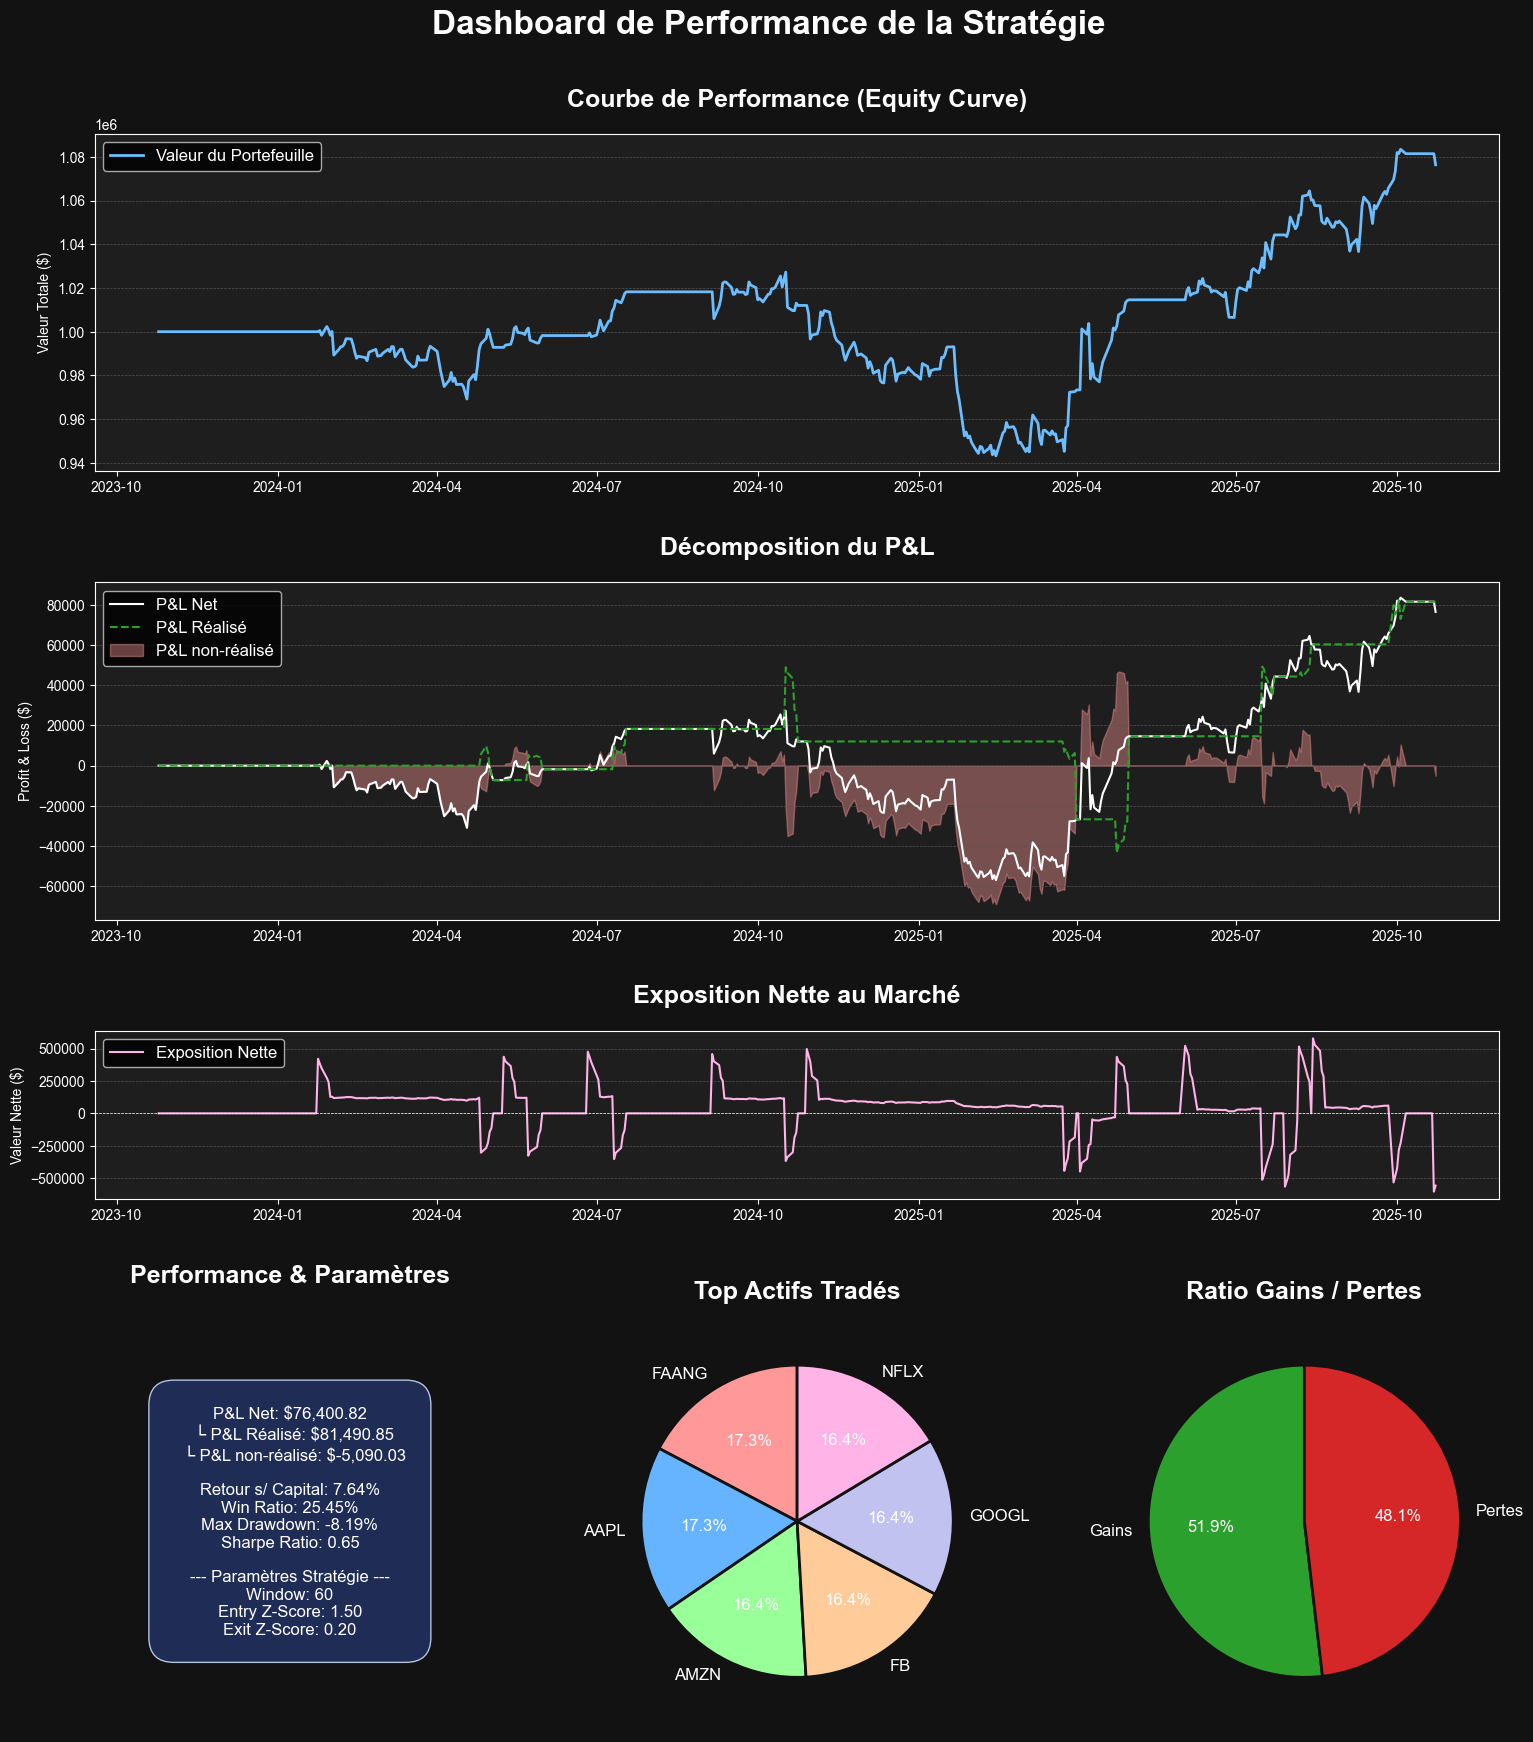

In [10]:
# 5. AFFICHAGE DU DASHBOARD

create_trading_dashboard(engine, strategy_params)

## 6. Interprétation des Indicateurs de Performance (KPIs)

L'évaluation d'une stratégie de trading ne se limite pas à son profit final. Les indicateurs suivants permettent d'analyser son comportement, son efficacité et son profil de risque de manière rigoureuse.

---

* **P&L Net (Net P&L)**
    C'est la performance globale et totale de la stratégie à un instant T. Il représente la somme du P&L déjà encaissé et du P&L latent des positions encore ouvertes. C'est l'indicateur le plus fidèle de la valeur actuelle de la performance.

* **P&L Réalisé (Realized P&L)**
    Le profit ou la perte net(te) après la clôture de toutes les positions et la déduction de l'ensemble des coûts de transaction. Il représente le gain ou la perte monétaire final et définitif de la stratégie.

* **P&L non-réalisé (Unrealized P&L)**
    La valeur "sur papier" des positions qui sont encore ouvertes sur le marché. Ce chiffre fluctue constamment avec les prix et représente le gain ou la perte que l'on obtiendrait si l'on clôturait toutes les positions immédiatement.

* **Retour sur Capital (Return on Capital)**
    Le P&L Net final exprimé en pourcentage du capital initial. C'est une mesure normalisée de la rentabilité, essentielle pour comparer les performances.

* **Win Ratio**
    Le ratio du nombre de trades profitables sur le nombre total de trades complétés. Un ratio faible n'est pas rédhibitoire si les gains moyens sont significativement supérieurs aux pertes moyennes.

* **Volatilité Annualisée (Annualized Volatility)**
    La mesure de l'amplitude des variations de la valeur du portefeuille. Elle quantifie le "risque" en termes de dispersion des rendements. Une faible volatilité est recherchée pour une croissance plus stable.

* **Max Drawdown**
    La perte maximale en pourcentage entre un pic historique et le creux qui a suivi. Il représente la pire série de pertes qu'un investisseur aurait eu à subir et quantifie le risque de perte en capital.

* **Ratio de Sharpe (Sharpe Ratio)**
    La principale mesure du rendement ajusté au risque. Il calcule le sur-rendement par unité de risque (volatilité). Un ratio supérieur à 1 est l'objectif, car il indique une performance efficace.